In [27]:
#Importing the libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')


In [28]:
#Loading the Dataset
df = pd.read_csv('loan_data.csv')
df.head()

,Gender,Married,ApplicantIncome,LoanAmount,Loan_Status
0,Male,Yes,4583,128000.0,N
1,Male,Yes,3000,66000.0,Y
2,Male,Yes,2583,120000.0,Y
3,Male,No,6000,141000.0,Y
4,Male,Yes,5417,267000.0,Y


In [29]:
df.shape

(577, 5)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           577 non-null    object 
 1   Married          577 non-null    object 
 2   ApplicantIncome  577 non-null    int64  
 3   LoanAmount       577 non-null    float64
 4   Loan_Status      577 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 22.7+ KB


In [7]:
df.describe()


,ApplicantIncome,LoanAmount
count,577.000000,577.000000
mean,5297.119584,144968.804159
std,5853.236196,82704.181660
min,150.000000,9000.000000
25%,2889.000000,100000.000000
50%,3800.000000,127000.000000
75%,5746.000000,167000.000000
max,81000.000000,650000.000000


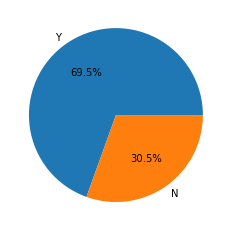

In [31]:
#Exploratory Data Analysis
#Piechart for LoanStatus column.
temp = df['Loan_Status'].value_counts()
plt.pie(temp.values,labels=temp.index,autopct='%1.1f%%')
plt.show()


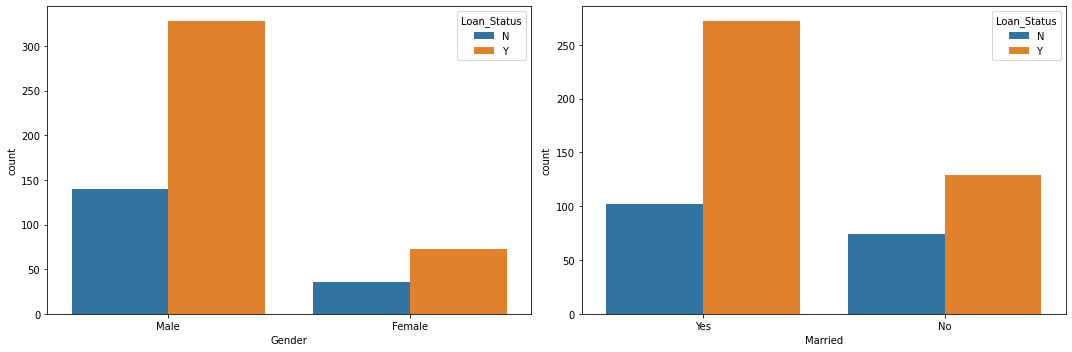

In [10]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['Gender', 'Married']):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df, x=col, hue='Loan_Status')
plt.tight_layout()
plt.show()

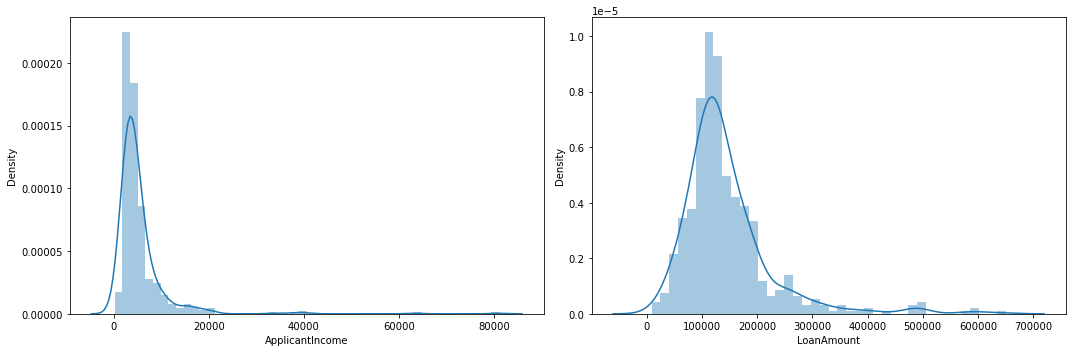

In [13]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['ApplicantIncome', 'LoanAmount']):
    plt.subplot(1, 2, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

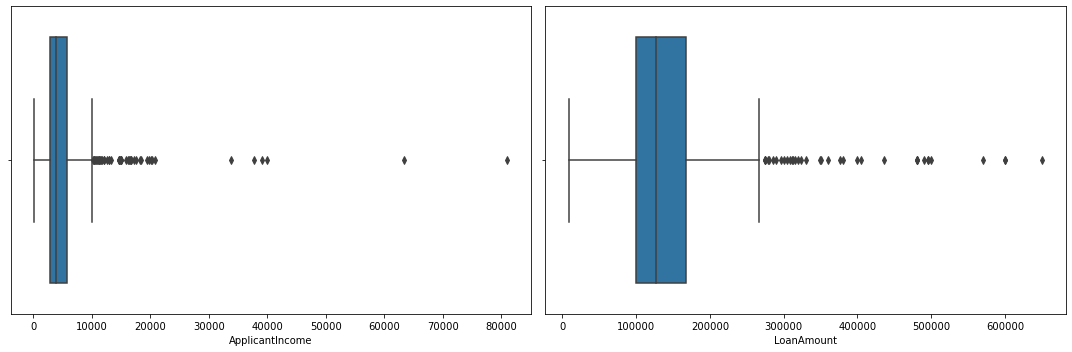

In [14]:
#Boxplot to find the outliers.
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['ApplicantIncome', 'LoanAmount']):
    plt.subplot(1, 2, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()


In [18]:
#Removing Outliers.
df = df[df['ApplicantIncome'] < 25000]
df = df[df['LoanAmount'] < 400000]

#Grouping based on gender to find the mean loan amount for each gender.
df.groupby('Gender').mean()['LoanAmount']

Gender
Female    118822.429907
Male      139289.823009
Name: LoanAmount, dtype: float64

In [19]:
#Grouping based on Marriage status as well as Gedner.
df.groupby(['Married', 'Gender']).mean()['LoanAmount']

Married  Gender
No       Female    116115.384615
         Male      126644.628099
Yes      Female    126103.448276
         Male      143912.386707
Name: LoanAmount, dtype: float64

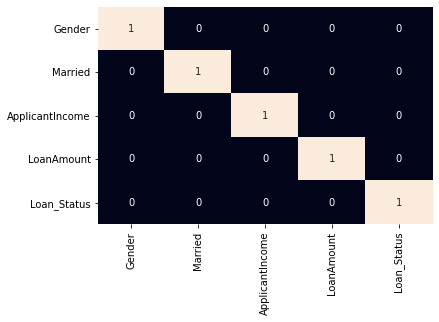

In [20]:
# Function to apply label encoding
def encode_labels(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])

    return data

# Applying function in whole column
df = encode_labels(df)

# Generating Heatmap
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()

In [21]:
#Data Preprocessing - splitting into train and validation 
features = df.drop('Loan_Status', axis=1)
target = df['Loan_Status'].values
 
X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)
 
# As the data was highly imbalanced we will balance it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
 
X_train.shape, X.shape

((447, 4), (616, 4))

In [22]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

In [23]:
#Using Support Vector Classifier to train the model.
from sklearn.metrics import roc_auc_score
model = SVC(kernel='rbf')
model.fit(X, Y)
 
print('Training Accuracy : ', metrics.roc_auc_score(Y, model.predict(X)))
print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, model.predict(X_val)))
print()

Training Accuracy :  0.6136363636363635
Validation Accuracy :  0.4908403026682596



In [24]:
#Model Evaluation
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
training_roc_auc = roc_auc_score(Y, model.predict(X))
validation_roc_auc = roc_auc_score(Y_val, model.predict(X_val))
print('Training ROC AUC Score:', training_roc_auc)
print('Validation ROC AUC Score:', validation_roc_auc)
print()
cm = confusion_matrix(Y_val, model.predict(X_val))


Training ROC AUC Score: 0.6136363636363635
Validation ROC AUC Score: 0.4908403026682596



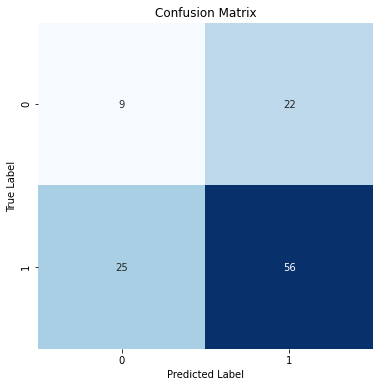

In [25]:
#Confusion Matrix
plt.figure(figsize=(6, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [32]:
#Performance Report
from sklearn.metrics import classification_report
print(classification_report(Y_val, model.predict(X_val)))


              precision    recall  f1-score   support

           0       0.26      0.29      0.28        31
           1       0.72      0.69      0.70        81

    accuracy                           0.58       112
   macro avg       0.49      0.49      0.49       112
weighted avg       0.59      0.58      0.59       112

